### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from skopt.space import Categorical, Integer, Real 

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory created!
Directory created!


In [4]:
for i in ['RandomForest', 'SVM_rbf', 'SVM_poly', 'LightGBM', 'XGBoost']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!
Directory created!
Directory created!
Directory created!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
        'ifs_total_score','mini_sea_total', 'npi_total', 'cognition',  'functionality', 'strata']

In [7]:
# test[cols].dropna()

In [8]:
# def impute_mean(group):
#     return group.fillna(group.mean())

# nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

# for i in nan_cols:
#     train[i] = train[i].transform(impute_mean)
    
# nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

# for i in nan_cols:
#     test[i] = test[i].transform(impute_mean)

train = train[cols].dropna()
test = test[cols].dropna()

In [9]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
#               'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total',
#               'pfeffer_total','cognition', 'functionality', 'marital_status', 'n_children',
#               'household_members', 'household_income', 'Job_status', 'strata']

final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
              'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'mmse_vs', 'moca_vs','ace_vs',
              'functionality', 'marital_status', 'n_children', 'household_members', 'household_income',
              'Job_status', 'strata']

final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',#'ifs_total_score',
              'mini_sea_total', 'npi_total', 'cognition',  'functionality', 'strata']


train = train[final_cols]
test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [10]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'mini_sea_total', 'npi_total', 'cognition', 'functionality', 'strata'],
      dtype='object')

In [11]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((184, 8), (22, 8))

In [12]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [13]:
### Load Hyperparams
# hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-23/mean_hparams/"
# xgb_hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-07/mean_hparams/" # Desktop
hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-12/mean_hparams/"


rf_hp = pd.read_csv(hparams_path + "RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

poly_hp = pd.read_csv(hparams_path + "SVC_Poly_hparams.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

xgb_hp = pd.read_csv(hparams_path + "xgb_hparams.csv", usecols=['param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_colsample_bytree','param_min_child_weight',
        'params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [14]:
rf_row = 0
rf_hp.iloc[rf_row,:]

param_criterion                                                         gini
param_max_depth                                                            5
param_max_features                                                        10
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       309
params                     OrderedDict([('criterion', 'gini'), ('max_dept...
mean_test_score                                                     0.872814
mean_train_score                                                    0.944521
Name: 0, dtype: object

In [15]:
poly_row = 0
poly_hp.iloc[0,: ]

param_C                                                      3.208079
param_coef0                                                       100
param_degree                                                        2
param_gamma                                                  0.659135
params              OrderedDict([('C', 3.208079260205241), ('coef0...
mean_test_score                                              0.828492
mean_train_score                                             0.884649
Name: 0, dtype: object

In [16]:
xgb_row=0
xgb_hp.iloc[0, :]

param_colsample_bytree                                                  1.0
param_learning_rate                                                0.204802
param_max_depth                                                           7
param_min_child_weight                                                   15
param_n_estimators                                                     1000
params                    OrderedDict([('colsample_bytree', 1.0), ('eval...
mean_test_score                                                    0.845185
mean_train_score                                                   0.907781
Name: 0, dtype: object

In [17]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

#Poly
poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
              'gamma': poly_hp.loc[poly_row, "param_gamma"],
               'coef0': poly_hp.loc[poly_row, "param_coef0"],
               'degree': poly_hp.loc[poly_row, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0, 'max_iter':10**6}

#XGBOOST
xgb_params = {
    'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
    'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
    'colsample_bytree': xgb_hp.loc[xgb_row, 'param_colsample_bytree'],
    'min_child_weight': xgb_hp.loc[xgb_row, 'param_min_child_weight'],
    'gamma': 1,
    'subsample':1.0,
#     'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

# xgb_params ={'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'gamma': 0.8045117829208245,
#              'learning_rate': 0.06547359028644324, 'max_depth': 4, 'n_estimators': 100,
#              'objective': 'binary:logistic', 'reg_alpha': 0.0, 'reg_lambda': 0.9798465147079346,
#              'subsample': 0.8,'n_jobs': -1,'verbosity':0}

In [18]:
n_iter = 100

### Base model: Logistic Regression

In [19]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating:   0%|                              | 0/100 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Iterating:   4%|▉                     | 4/100 [00:00<00:02, 32.39it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Iterating:  68%|██████████████▎      | 68/100 [00:01<00:00, 39.51it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Iterating:  73%|███████████████▎     | 73/100 [00:01<00:00, 39.91it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples.

singular_matrix_errors (droped from results): 0
Eleapsed time:0.04327104886372884 minutes
empirical p-value: 0.07


invalid value encountered in sqrt


In [20]:
lr_res.mean()

Accuracy         0.833548
ROC_AUC          0.816846
Precision        0.000000
Recall           0.000000
Sensitivity      0.000000
Specificity      0.993846
F1               0.000000
Efron_pR2        0.149099
mcfadden_pR2     0.169939
mcfadden_apR2   -0.081234
dtype: float64

In [21]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.073007,0.075811,0.0,0.0,0.0,0.015328,0.0,0.069813,0.073614,NaN


In [22]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,cognition,0.292276,0.204145,0.559691,0.435061,0.970132,0.005702
1,functionality,1.116858,0.207566,1.994174,0.547829,0.137912,0.048712
2,mini_sea_total,-1.455320,0.248309,-2.220809,0.630344,0.090873,0.033045
3,npi_total,0.607293,0.230132,1.273032,0.503999,0.460858,0.098136
4,sex,-0.831614,0.189987,-4.933733,1.177998,0.000707,0.002071


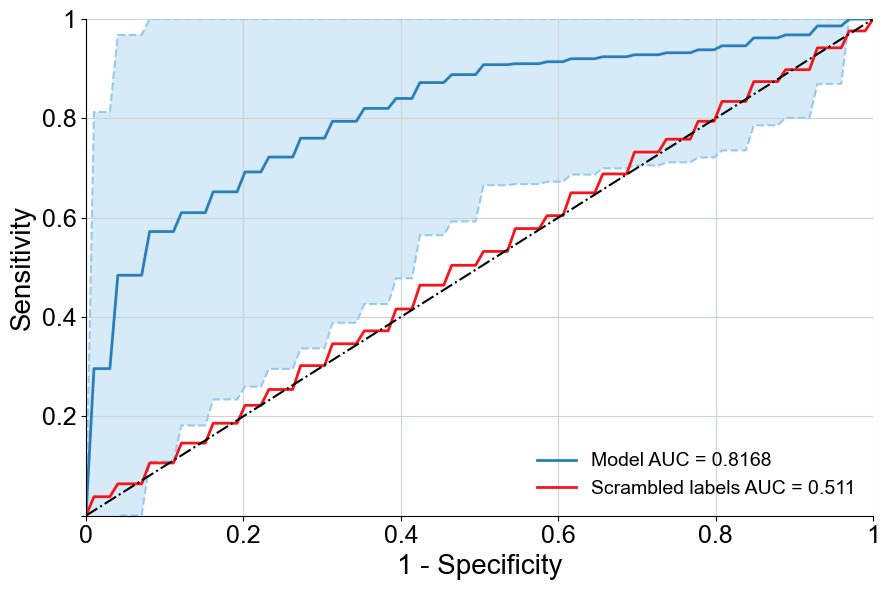

In [23]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [24]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [25]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

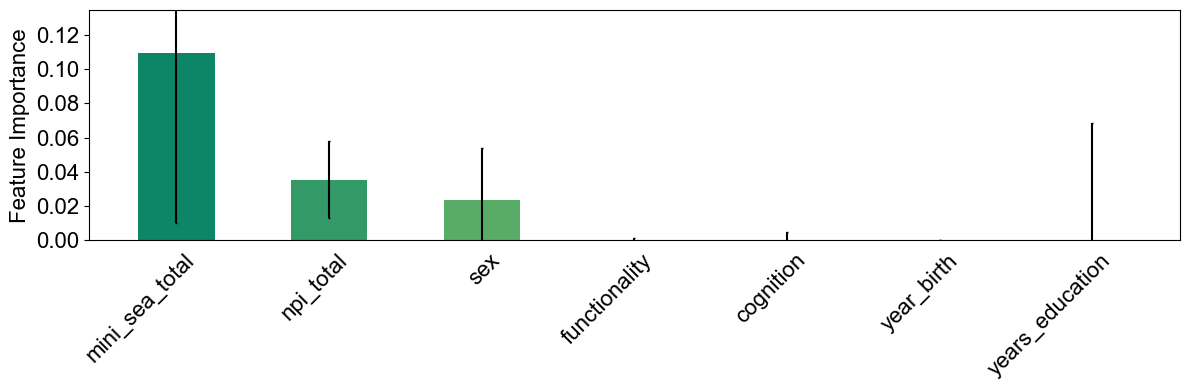

In [26]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

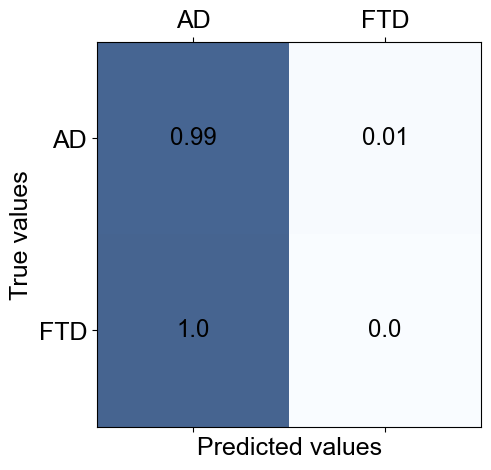

In [27]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [28]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [29]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [30]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [31]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [32]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.5
Accuracy: 0.7895
Recall: 0.0
F1: 0.0
Precision:0.0


In [33]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.5
Bootstrping test ROC score: 	0.8168


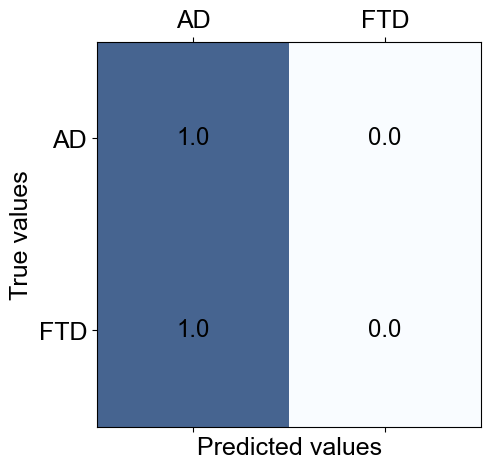

In [34]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'])

### RF Model

##### Bootstrap

In [37]:
rf_params['max_features']= 7

In [38]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=7,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       n_estimators=309, n_jobs=-1)


Iterating: 100%|████████████████████| 100/100 [00:53<00:00,  1.85it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:0.8989515185356141 minutes
empirical p-value: 0.03


In [39]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-11-14/mean_res'

In [40]:
# Model_res.to_csv(path_res+ "/RandomForest/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.889355
ROC_AUC        0.892423
Precision      0.724960
Recall         0.568000
Sensitivity    0.568000
Specificity    0.951154
F1             0.608629
Efron_pR2      0.365310
dtype: float64

In [41]:
print("%.4f" % Model_res['ROC_AUC'].mean())

0.8924


In [44]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.063096,0.063427,0.090415,0.097686,0.097686,0.043334,0.096708,0.092876


In [44]:
# Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
2,mini_sea_total,0.513606,0.063327
6,years_education,0.125186,0.046498
3,npi_total,0.117597,0.023636
1,functionality,0.102747,0.029244
0,cognition,0.083138,0.025967
5,year_birth,0.047596,0.018488
4,sex,0.010131,0.005837


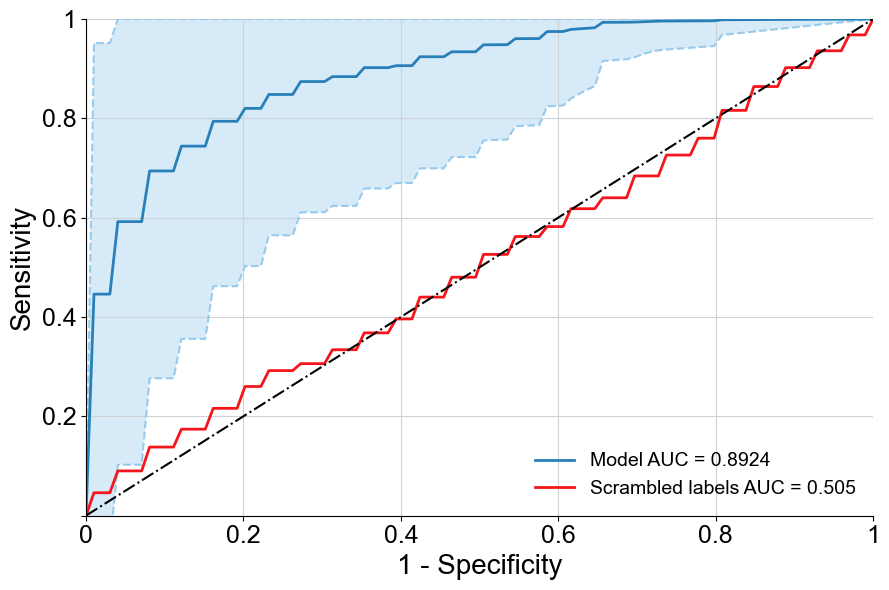

In [42]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=None)#path_res+ "/RandomForest/ROC_AUC_curve.png")
# Fig save?


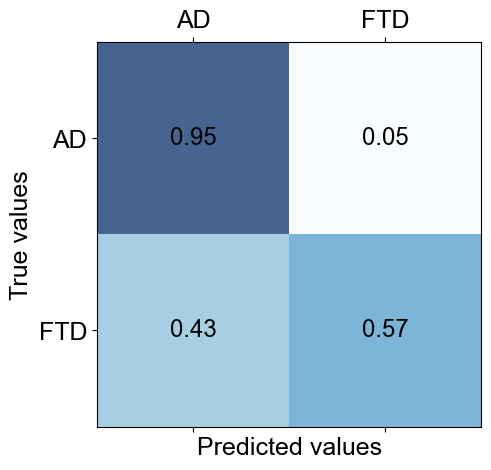

In [43]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=None)#path_res+ "/RandomForest/CM.png")

##### Permutation Feature importance

In [48]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [49]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [50]:
top_10p.head()

,predictor,mean,std
4,mini_sea_total,0.339308,0.106293
5,npi_total,0.060769,0.035343
0,year_birth,0.016462,0.006795
7,functionality,0.013923,0.012293
6,cognition,0.012846,0.014228


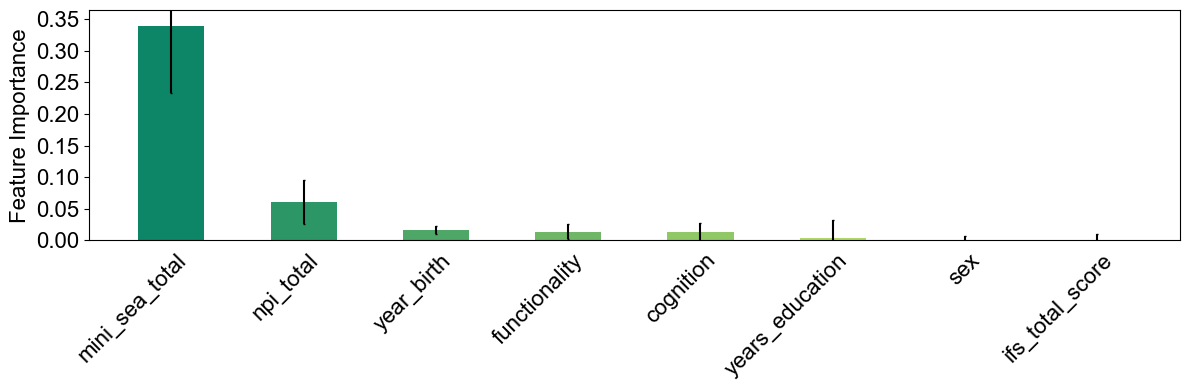

In [51]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [52]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
3,mini_sea_total,0.481011,0.077224
7,years_education,0.124824,0.045985
4,npi_total,0.102669,0.023910
1,functionality,0.082861,0.026996
0,cognition,0.078000,0.025262


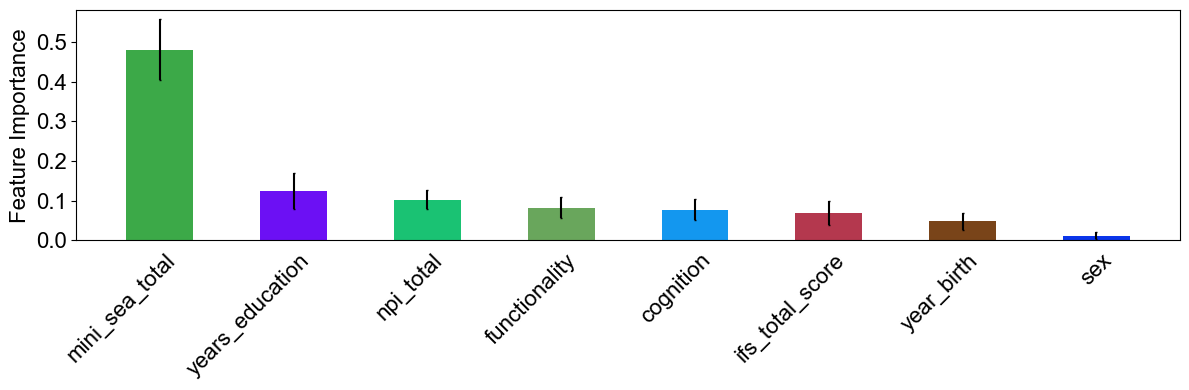

In [53]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [54]:
# X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
# X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [51]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [52]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")
unseen_df

,ROC AUC,Accuracy,Sensitivity,Recall,F1,Precision
0,0.75,0.8947,1.0,0.5,0.6667,1.0


In [47]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.75
Accuracy: 0.8947
Recall: 0.5
F1: 0.6667
Precision:1.0


In [48]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.75
Bootstrping test ROC score: 	0.8924


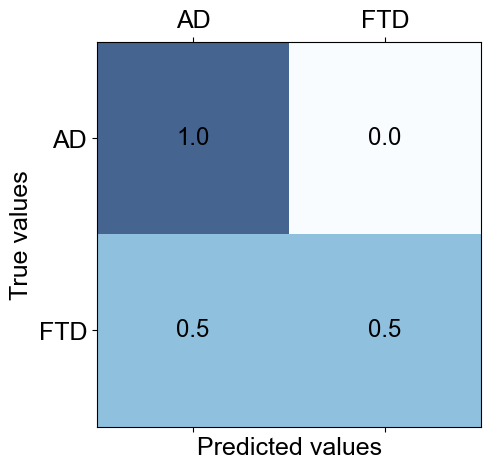

In [49]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'])

#### Shapley

In [60]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


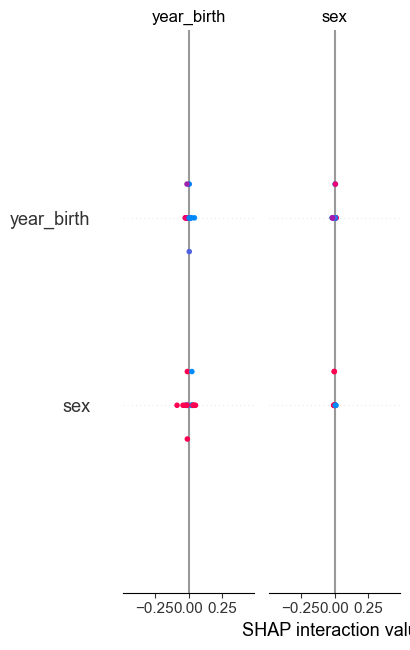

In [61]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

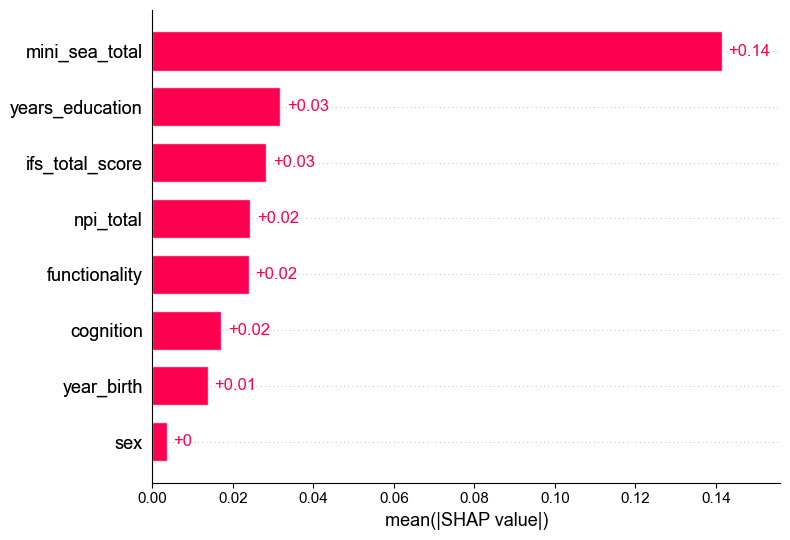

In [62]:
shap.plots.bar(shap_values[:,:,1])

In [57]:
# shap.plots.beeswarm(shap_values[:,:,1])

In [58]:
# # compute SHAP values
# explainer2 = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
# shap_values2 = explainer(X_test, check_additivity=False)

In [59]:
# shap.summary_plot(shap_values2[:,:,1])

In [60]:
# shap.plots.bar(shap_values2[:,:,1])

In [61]:

# # Convertir shap_values en un DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

# # Guardar el DataFrame en un archivo CSV
# shap_df.to_csv('shap_values.csv', index=False)


In [62]:
# shap_values2[:,:,1]

### SVM - Poly

#### Bootstrap

In [63]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

SVC(C=3.208079260205241, class_weight='balanced', coef0=100, degree=2,
    gamma=0.6591346153501173, kernel='poly', max_iter=1000000, verbose=0)


Iterating: 100%|██████████████████| 5000/5000 [12:17<00:00,  6.78it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:12.295335654417674 minutes
empirical p-value: 0.0


In [64]:
p_Model_res.to_csv(path_res+ "/SVM_poly/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.768814
ROC_AUC        0.760920
Precision      0.508946
Recall         0.745974
Sensitivity    0.745974
Specificity    0.775866
F1             0.603694
dtype: float64

In [65]:
p_CI_df.to_csv(path_res+ "/SVM_poly/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.011686
ROC_AUC_ci        0.011823
Precision_ci      0.013857
Recall_ci         0.012066
Sensitivity_ci    0.012066
Specificity_ci    0.011559
F1_ci             0.013558
dtype: float64

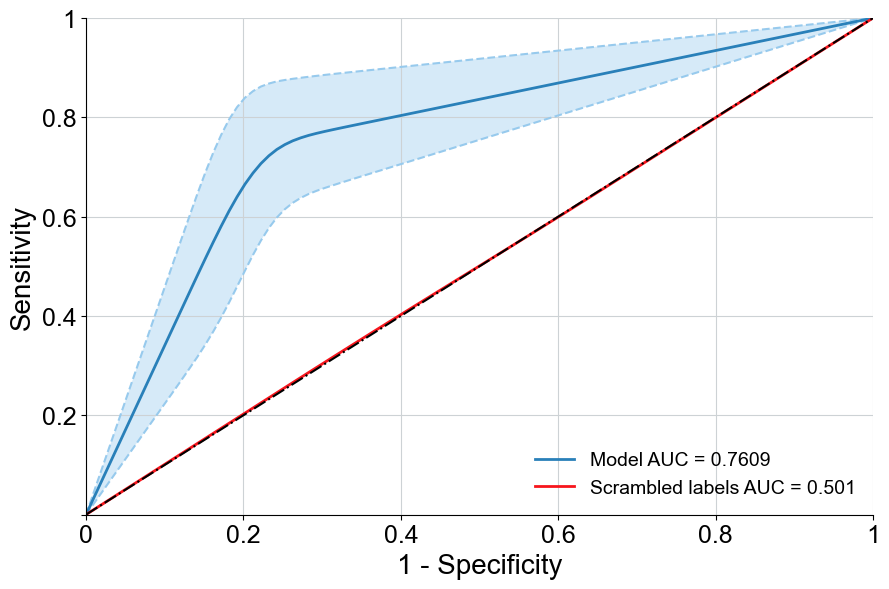

In [66]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly/poly_ROC_AUC_curve.png")

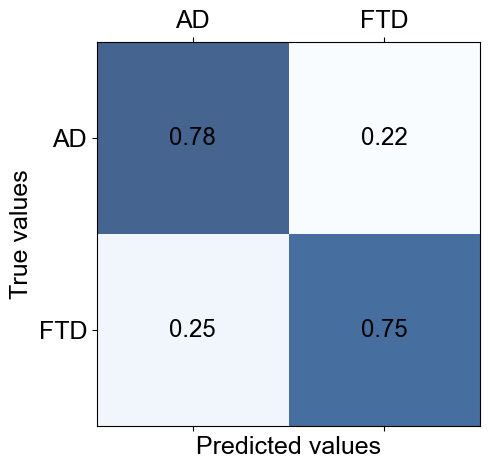

In [67]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_CM.png")

#### Permutation Feature importance

In [68]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=n_iter, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly/poly_PFI.csv")
top_10_poly = p_fimp.sort_values('mean', ascending=False).head(10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


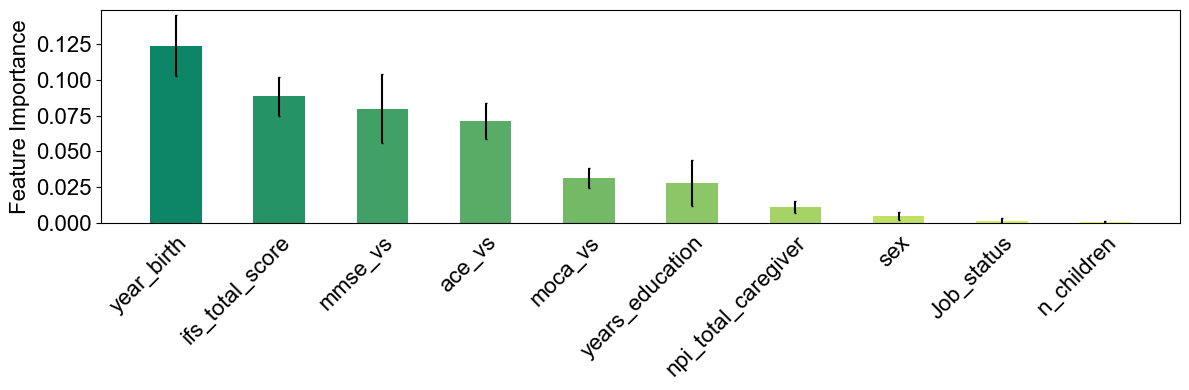

In [69]:
ml_plotting.plot_permutation_FIMP(top_10_poly, names='predictor', importances_col='mean', std_col='std')

#### Unseen data

In [70]:
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)
y_pred = poly.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [71]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/SVM_poly/poly_PFI.csv")

In [72]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.8146
Accuracy: 0.8224
Recall: 0.8
F1: 0.678
Precision:0.5882

Unseen Data ROC score: 		0.8146
Bootstrping test ROC score: 	0.7609


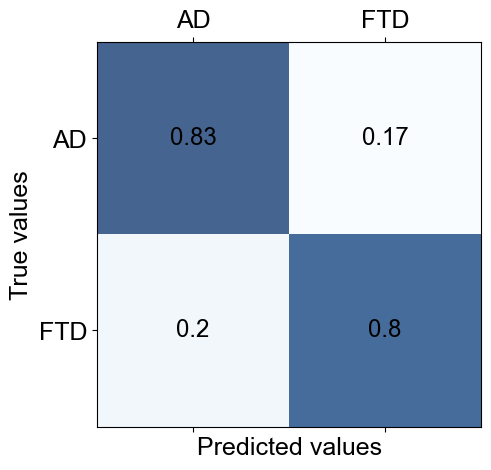

In [73]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'])

#### Shapley

In [74]:
poly_params['probability'] = True

In [75]:
# compute SHAP values
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)

masker=shap.maskers.Independent(X_train, max_samples=1)
# explainer = shap.KernelExplainer(model=svc_rbf.predict, data=X_train, masker=masker)
explainer = shap.KernelExplainer(model=poly.predict_proba, data=masker.data)
shap_values = explainer.shap_values(X_train, masker = masker)
# explainer = shap.KernelExplainer(model.predict, X_train_summary, masker=background)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/974 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

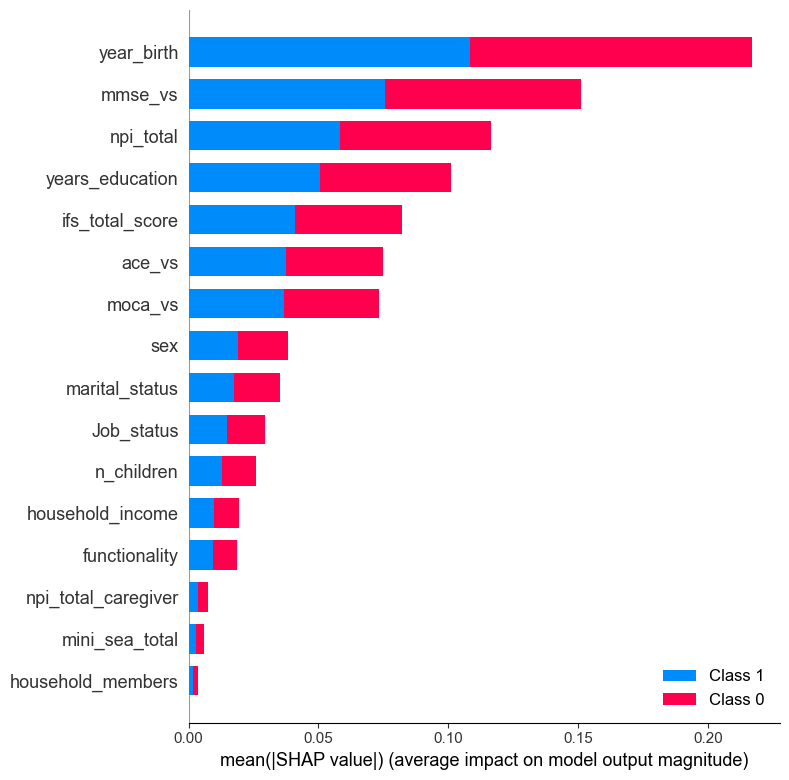

In [76]:
shap.summary_plot(shap_values, feature_names=X_train.columns)
# shap.summary_plot(shap_values[:,:,:1], feature_names=X_train.columns)

### XGBoost

In [77]:
# xgb_sfe_cols = xgb_sfe_cols + ['diagnosis']

#### Bootstrap

In [78]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

Iterating: 100%|██████████████████| 5000/5000 [08:32<00:00,  9.76it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:8.54239802757899 minutes
empirical p-value: 0.0


In [79]:
# xgb_Model_res.to_csv(path_res+ "/XGBoost/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.837287
ROC_AUC        0.855140
Precision      0.708978
Recall         0.533674
Sensitivity    0.533674
Specificity    0.931020
F1             0.605989
Efron_pR2      0.343995
dtype: float64

In [80]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
14,year_birth,37.284400,5.075694,7.018415,1.055250
5,ifs_total_score,27.333400,4.129607,11.457280,1.977192
1,ace_vs,22.064200,5.394951,7.161159,1.843845
15,years_education,21.403000,3.902004,3.506060,0.593870
9,moca_vs,15.924200,4.480811,2.216086,0.488317
11,npi_total,13.430000,3.011530,2.479695,0.451474
6,marital_status,7.776000,1.788425,6.483554,1.631924
2,functionality,6.906916,2.888083,2.325544,0.694175
8,mmse_vs,5.810150,2.811242,2.860940,1.359621
13,sex,5.412178,2.130214,2.227196,0.572655


In [81]:
xgb_CI_df.to_csv(path_res+ "/XGBoost/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010231,0.009756,0.012591,0.013828,0.013828,0.007024,0.013544,0.013167


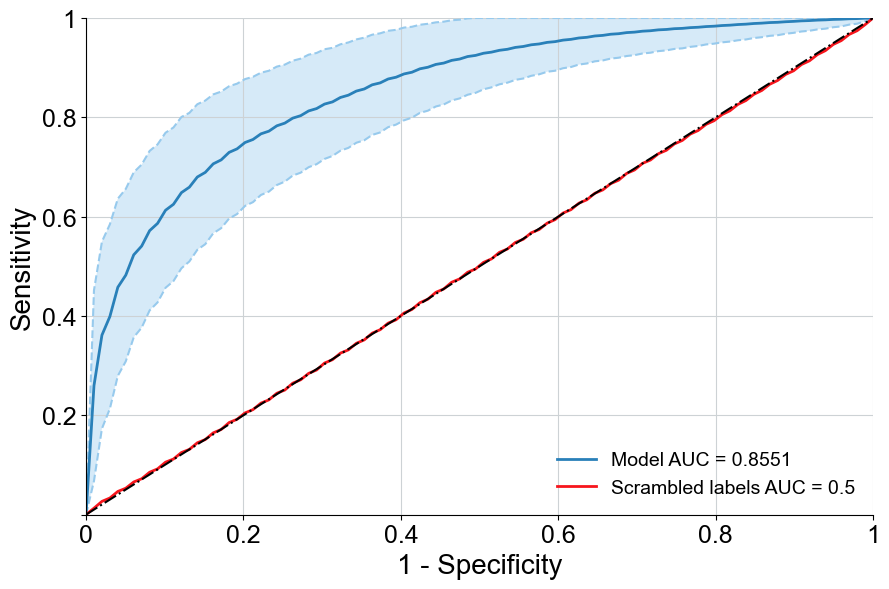

In [82]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost/xgb_ROC.png")

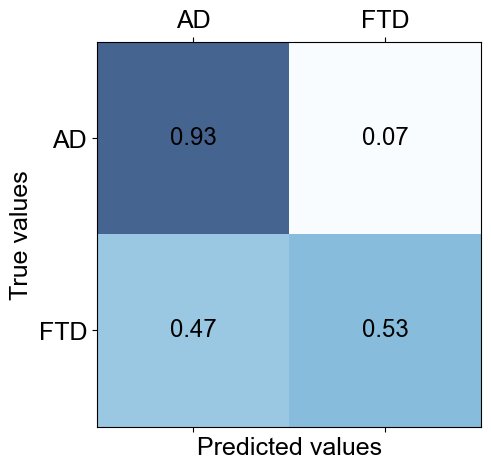

In [83]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=None)#path_res+ "/XGBoost/xgb_CM.png")

#### Permutation Feature importance

In [84]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost/xgb_PFI.csv")
top_10_xgb=xgb_fimp.sort_values('mean', ascending=False).head(10)

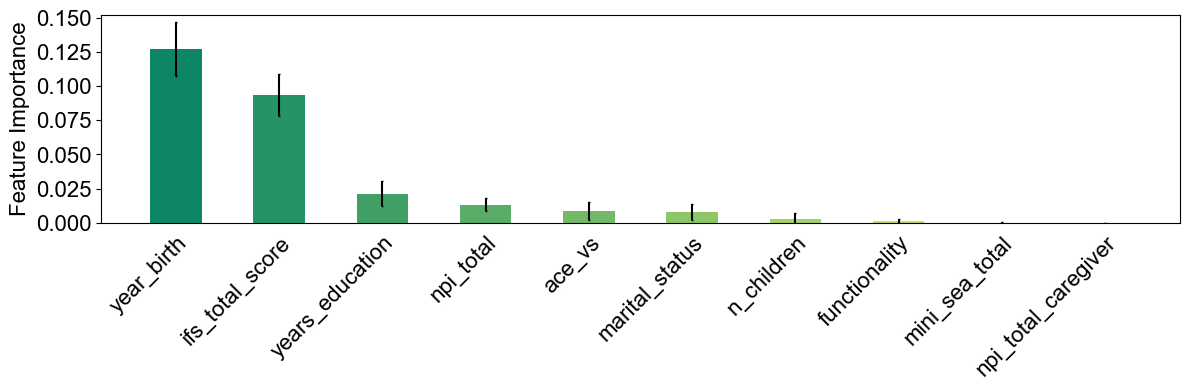

In [85]:
ml_plotting.plot_permutation_FIMP(top_10_xgb, names='predictor', importances_col='mean', std_col='std')

In [86]:
xgb_Model_res_r

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
0,Job_status,2.199090,1.156354,4.351126,2.224993
1,ace_vs,22.064200,5.394951,7.161159,1.843845
2,functionality,6.906916,2.888083,2.325544,0.694175
3,household_income,1.512476,0.711733,3.622603,1.432498
4,household_members,1.000000,0.000000,8.553168,2.565017
5,ifs_total_score,27.333400,4.129607,11.457280,1.977192
6,marital_status,7.776000,1.788425,6.483554,1.631924
7,mini_sea_total,2.979578,1.443861,1.686606,0.831315
8,mmse_vs,5.810150,2.811242,2.860940,1.359621
9,moca_vs,15.924200,4.480811,2.216086,0.488317


In [87]:
top_10_xgb = xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)
top_10_xgb

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
14,year_birth,37.284400,5.075694,7.018415,1.055250
5,ifs_total_score,27.333400,4.129607,11.457280,1.977192
1,ace_vs,22.064200,5.394951,7.161159,1.843845
15,years_education,21.403000,3.902004,3.506060,0.593870
9,moca_vs,15.924200,4.480811,2.216086,0.488317
11,npi_total,13.430000,3.011530,2.479695,0.451474
6,marital_status,7.776000,1.788425,6.483554,1.631924
2,functionality,6.906916,2.888083,2.325544,0.694175
8,mmse_vs,5.810150,2.811242,2.860940,1.359621
13,sex,5.412178,2.130214,2.227196,0.572655


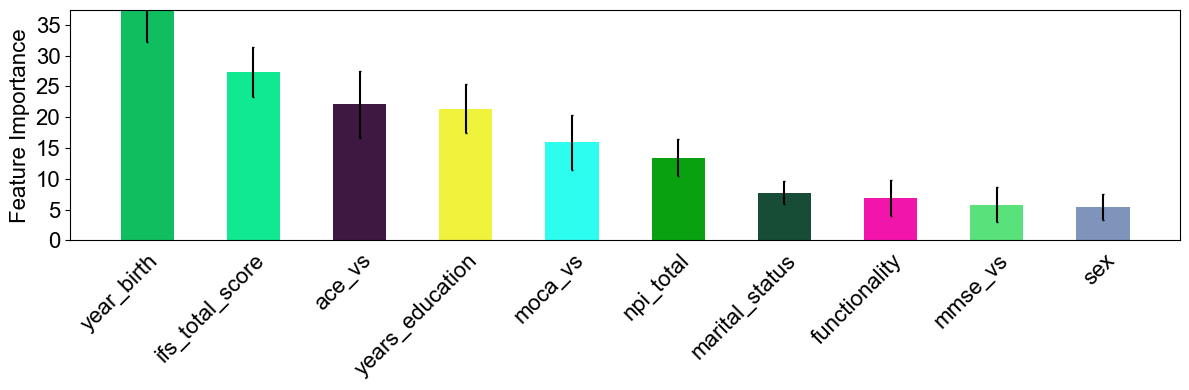

In [88]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_f_score_mean', 'Importance_f_score_std')

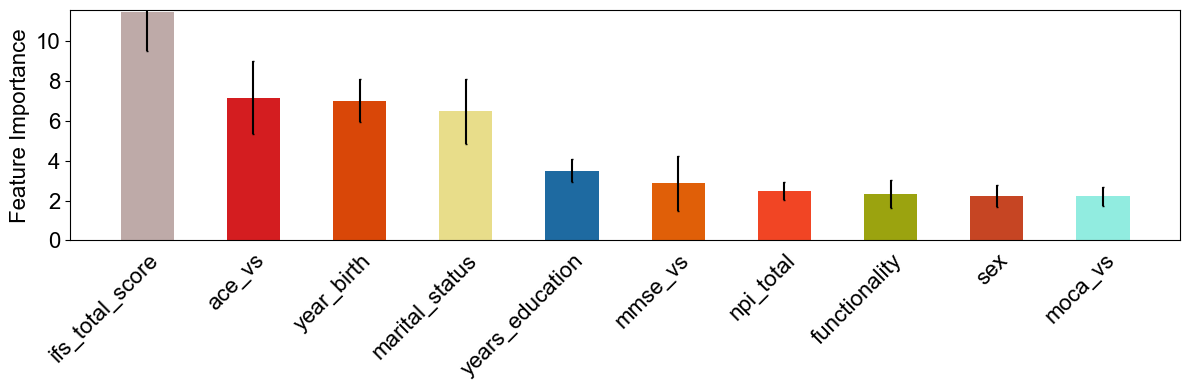

In [89]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_gain_mean', 'Importance_gain_std')

#### Unseen data

In [90]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [91]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/XGBoost/xgb_PFI.csv")

In [92]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.8078
Accuracy: 0.8972
Recall: 0.64
F1: 0.7442
Precision:0.8889

Unseen Data ROC score: 		0.8078
Bootstrping test ROC score: 	0.8551


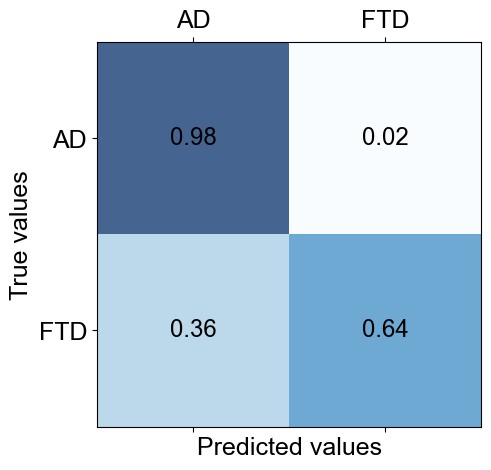

In [93]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'])

#### Shapley

In [94]:
# # compute SHAP values
explainer = shap.explainers.Tree(xgb, X_train, feature_names=X_train.columns.tolist())
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


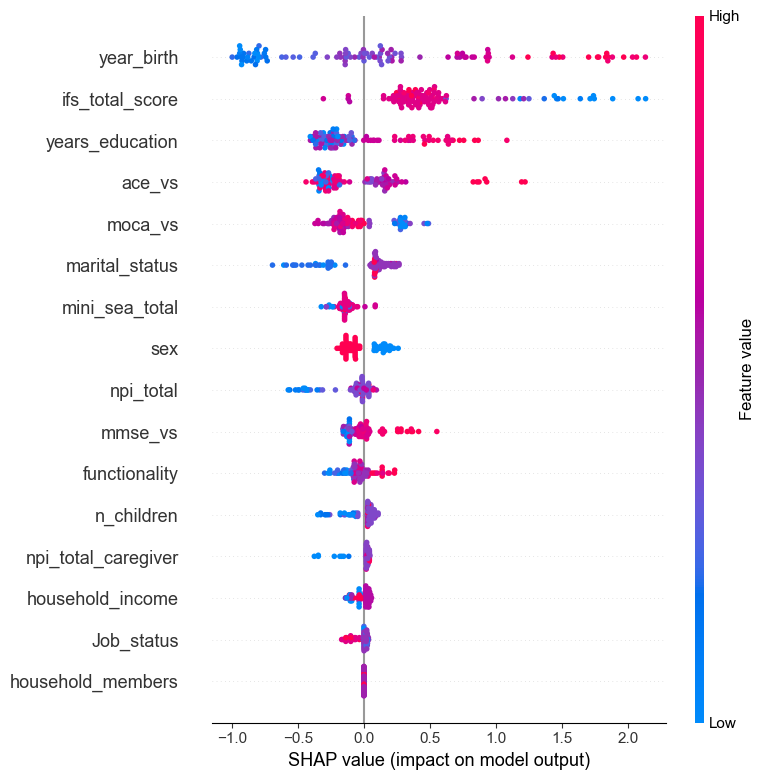

In [95]:
shap.summary_plot(shap_values, feature_names=X_unseen.columns)

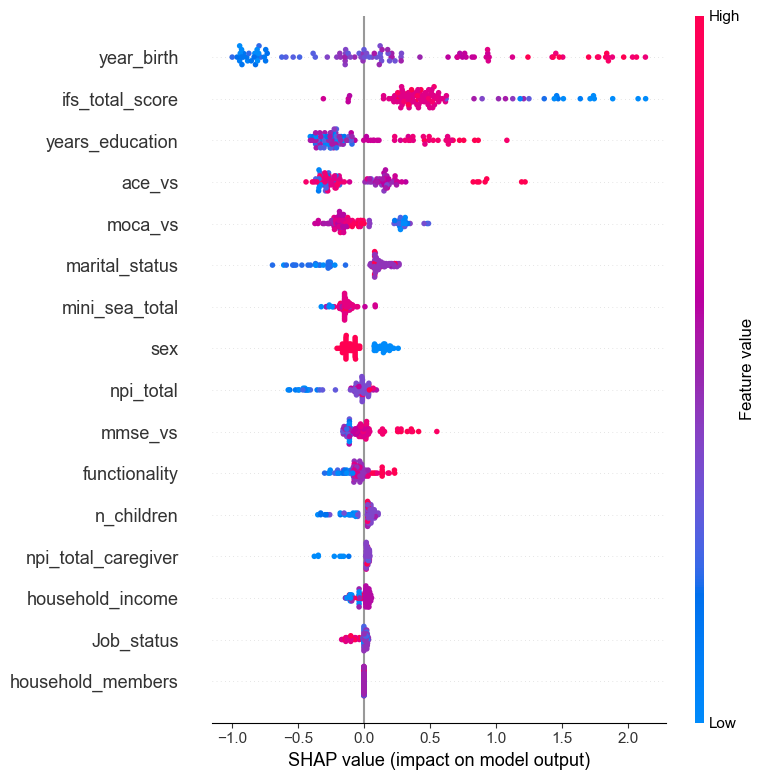

In [96]:
shap.summary_plot(shap_values)

In [97]:
#shap.plots.bar(shap_values)

### Sequential feature selector

#### RF

In [98]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [99]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [100]:
rf_params

{'n_estimators': 309,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 0.01,
 'min_samples_leaf': 0.01,
 'max_features': 10,
 'class_weight': 'balanced',
 'verbose': 0,
 'n_jobs': -1}

In [101]:
sfs_rfc = SFS(RandomForestClassifier(**rf_params), 
           k_features='best', 
           forward=False, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [102]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    2.8s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.0s finished
Features: 15/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.9s finished
Features: 14/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    2.8s finished
Features: 13/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    2.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    2.6s finished
Features: 12/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    2.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  12 

Features: 6/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/marcelo/ana

Features: 5/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/marcelo/ana

Features: 4/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/marcelo/ana

Features: 3/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
Features: 2/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
Features: 1/1

In [103]:
sfs_rf = pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

In [104]:
sfs_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
16,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.803076923076923, 0.7846153846153846, 0.8086...",0.798778,"(year_birth, sex, years_education, ifs_total_s...",0.023109,0.010269,0.007261
15,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,...","[0.8123076923076923, 0.803076923076923, 0.8148...",0.810066,"(year_birth, sex, years_education, ifs_total_s...",0.011358,0.005047,0.003569
14,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15)","[0.8061538461538461, 0.8215384615384616, 0.814...",0.814169,"(year_birth, sex, years_education, ifs_total_s...",0.014171,0.006297,0.004453
13,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 14, 15)","[0.8, 0.8276923076923077, 0.8179012345679012]",0.815198,"(year_birth, sex, years_education, ifs_total_s...",0.025802,0.011466,0.008108
12,"(0, 1, 2, 3, 5, 6, 7, 8, 11, 12, 14, 15)","[0.8153846153846154, 0.8184615384615385, 0.811...",0.815192,"(year_birth, sex, years_education, ifs_total_s...",0.006193,0.002752,0.001946
11,"(0, 1, 2, 3, 5, 6, 7, 11, 12, 14, 15)","[0.8061538461538461, 0.8123076923076923, 0.811...",0.810063,"(year_birth, sex, years_education, ifs_total_s...",0.006244,0.002775,0.001962
10,"(0, 1, 2, 3, 5, 6, 7, 11, 14, 15)","[0.803076923076923, 0.8123076923076923, 0.8055...",0.80698,"(year_birth, sex, years_education, ifs_total_s...",0.008778,0.003901,0.002758
9,"(0, 1, 2, 3, 5, 6, 7, 11, 14)","[nan, nan, nan]",NaN,"(year_birth, sex, years_education, ifs_total_s...",NaN,NaN,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 11)","[nan, nan, nan]",NaN,"(year_birth, sex, years_education, ifs_total_s...",NaN,NaN,NaN
7,"(0, 1, 2, 3, 5, 6, 7)","[nan, nan, nan]",NaN,"(year_birth, sex, years_education, ifs_total_s...",NaN,NaN,NaN


In [105]:
sfs_rf.loc[[5],:]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
5,"(0, 1, 2, 3, 5)","[nan, nan, nan]",NaN,"(year_birth, sex, years_education, ifs_total_s...",NaN,NaN,NaN


In [106]:
# 5, 13
sfs_rf_features = list(sfs_rf.loc[5, 'feature_names'])

In [107]:
sfs_rf_features

['year_birth', 'sex', 'years_education', 'ifs_total_score', 'npi_total']

#### XBoost

In [108]:
sfs_xgb = SFS(xgboost.XGBClassifier(**xgb_params), 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [109]:
sfs_xgb = sfs_xgb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    0.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.7s finished
Features: 1/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.8s finished
Features: 2/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.9s finished
Features: 3/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.9s finished
Features: 4/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 

In [110]:
xgb_sfe = pd.DataFrame.from_dict(sfs_xgb.get_metric_dict()).T
xgb_sfe

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.7938461538461539, 0.7661538461538462, 0.808...",0.789547,"(ifs_total_score,)",0.039628,0.01761,0.012452
2,"(3, 9)","[0.8123076923076923, 0.7846153846153846, 0.839...",0.812143,"(ifs_total_score, ace_vs)",0.050428,0.022409,0.015846
3,"(3, 9, 11)","[0.8215384615384616, 0.7907692307692308, 0.839...",0.817271,"(ifs_total_score, ace_vs, marital_status)",0.045286,0.020124,0.01423
4,"(3, 9, 11, 15)","[0.8307692307692308, 0.7876923076923077, 0.851...",0.823438,"(ifs_total_score, ace_vs, marital_status, Job_...",0.060086,0.026701,0.018881
5,"(3, 5, 9, 11, 15)","[0.8246153846153846, 0.8061538461538461, 0.861...",0.830627,"(ifs_total_score, npi_total, ace_vs, marital_s...",0.051387,0.022835,0.016147
6,"(2, 3, 5, 9, 11, 15)","[0.8369230769230769, 0.803076923076923, 0.8611...",0.833704,"(years_education, ifs_total_score, npi_total, ...",0.053561,0.023801,0.01683
7,"(0, 2, 3, 5, 9, 11, 15)","[0.8338461538461538, 0.8276923076923077, 0.845...",0.835739,"(year_birth, years_education, ifs_total_score,...",0.016797,0.007464,0.005278
8,"(0, 2, 3, 5, 6, 9, 11, 15)","[0.8338461538461538, 0.8276923076923077, 0.845...",0.835739,"(year_birth, years_education, ifs_total_score,...",0.016797,0.007464,0.005278
9,"(0, 2, 3, 5, 6, 9, 11, 13, 15)","[0.8338461538461538, 0.8276923076923077, 0.845...",0.835739,"(year_birth, years_education, ifs_total_score,...",0.016797,0.007464,0.005278
10,"(0, 2, 3, 5, 6, 8, 9, 11, 13, 15)","[0.8276923076923077, 0.8369230769230769, 0.842...",0.835736,"(year_birth, years_education, ifs_total_score,...",0.013819,0.006141,0.004342


In [111]:
xgb_sfe_cols=list(xgb_sfe.loc[4, 'feature_names'])
xgb_sfe_cols

['ifs_total_score', 'ace_vs', 'marital_status', 'Job_status']

In [112]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

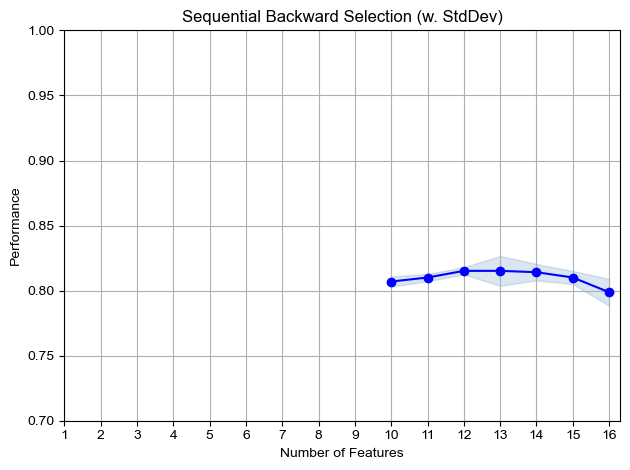

In [113]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

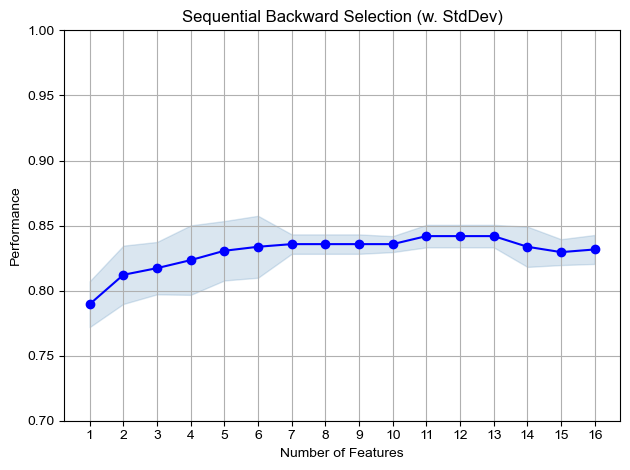

In [114]:
fig2 = plot_sfs(sfs_xgb.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### Shapley

In [115]:
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


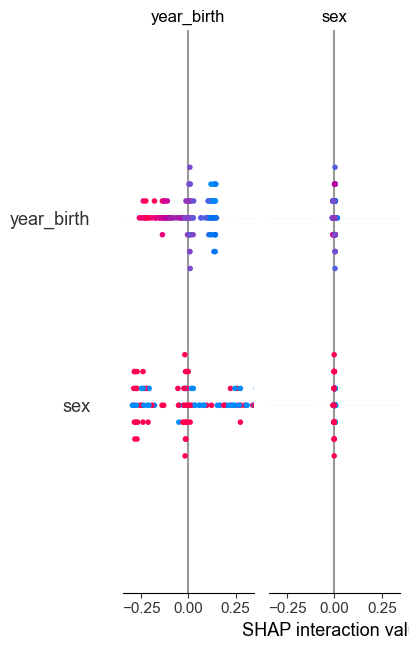

In [116]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

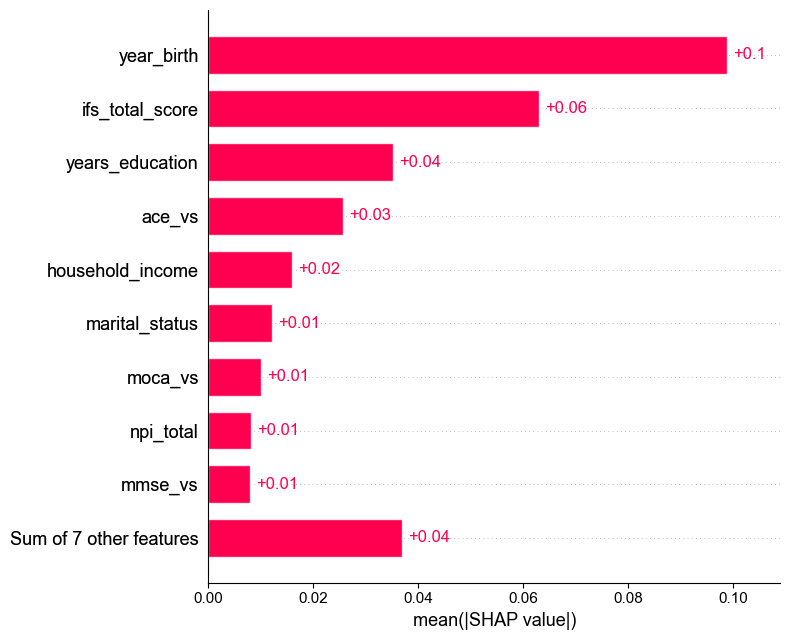

/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1061, in __c

/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1061, in __c

/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1061, in __c

/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1061, in __c

/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/marcelo/anaconda3/envs/sklearn-env/lib/python3.8/site-packages/joblib/parallel.py", line 1061, in __c

In [117]:
shap.plots.bar(shap_values[:,:,1])